In [19]:
from psaw import PushshiftAPI
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm
import datetime
import os
from itertools import islice
from collections import defaultdict
import networkx as nx
import nltk
import pickle
from community import community_louvain
import fasttext
import re
import scipy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from networkx.algorithms import community

In [20]:
data = pd.read_pickle(r'./data_cleaned.pkl')
data_submissions = data[data['is submission'] == True]
data_comments = data[data['is submission'] == False]

In [17]:
data

,author,body,created_utc,id,parent_id,link_id,subreddit,subreddit_id,is submission,readable_time,title,to_remove,Will Smith,Chris Rock,slap,oscar,Jada Pinkett,child_ids
0,tuesdaycocktail,Can we talk for a moment how well Chris Rock h...,1648504718,tqkhaj,tqkhaj,tqkhaj,Oscars,t5_2qrbm,True,28-Mar-2022 (23:58:38),Can we talk for a moment how well Chris Rock h...,False,False,True,False,False,False,[]
1,logfromrenandstimpy,Will Smith official Twitter Account Suspended,1648504582,tqkfqh,tqkfqh,tqkfqh,entertainment,t5_2qh0f,True,28-Mar-2022 (23:56:22),Will Smith official Twitter Account Suspended,False,True,False,False,False,False,[]
2,warwickd,Opinion: The elites are lying about the Will S...,1648504291,tqkcaf,tqkcaf,tqkcaf,television,t5_2qh6e,True,28-Mar-2022 (23:51:31),Opinion The elites are lying about the Will Sm...,False,True,False,True,False,False,"[i2hwmxn, i2huxdb, i2husoe, i2hu0dl, i2hrxjh, ..."
3,No_Power5785,Chris you know Better!,1648504176,tqkax1,tqkax1,tqkax1,willsmith,t5_2s9ed,True,28-Mar-2022 (23:49:36),Chris you know Better,False,False,True,False,False,False,[]
4,Boosted_J,Will Smith is,1648504064,tqk9h8,tqk9h8,tqk9h8,willsmith,t5_2s9ed,True,28-Mar-2022 (23:47:44),Will Smith is,False,True,False,False,False,False,[i2jlzmy]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189882,TiredFrisk,It's a fucking slap you piece of shit fuck off,1650241286,i55d0v2,i559w20,u5jdja,willsmith,t5_2s9ed,False,18-Apr-2022 (02:21:26),Its a fucking slap you piece of shit fuck off,False,False,True,True,False,False,[i55dhwq]
189883,realmufasa,His flip out was not just because of Chris's r...,1650239837,i559w20,i559w20,u5jdja,willsmith,t5_2s9ed,False,18-Apr-2022 (01:57:17),His flip out was not just because of Chriss re...,False,False,True,True,False,False,[i55d0v2]
189884,Solidplasticmonkey,I see both sides of it. So called “comedians” ...,1650188020,i52b21y,i52b21y,u5jdja,willsmith,t5_2s9ed,False,17-Apr-2022 (11:33:40),I see both sides of it So called comedians thi...,False,False,True,False,False,False,[]
189885,Any_questions__,He will probably lower their defense by slappi...,1650225998,i54eglf,u5iflm,u5iflm,willsmith,t5_2s9ed,False,17-Apr-2022 (22:06:38),He will probably lower their defense by slappi...,False,True,False,True,False,False,[]


In [71]:
get_author = {row['id']: row['author'] for _,row in tqdm(data.iterrows())}

115316it [00:03, 33522.85it/s]


In [86]:
def create_txt(data, save_location='/training_data.txt', v=True):
    """
    Takes a dataframe of posts or comments and creates a txt file to train fasttext
    """
    txts = []
    
    if v: print('Writing txt training file')
    for comment in tqdm(data['body']):
        comment = comment.lower()
        comment = re.sub('[^A-Za-z0-9 ]+', '', comment)
        
        txts.append(comment)
    
    txt = "\n".join(txts)
    
    save_location = os.getcwd() + save_location
    f = open(save_location, mode='w')
    f.write(txt)
    f.close()

def create_fasttext_model(path_to_data, *kwargs):
    """
    Creates fasttext unsupervised model - probably a skipgram or CBoW
    """
    # options at https://fasttext.cc/docs/en/python-module.html
    return fasttext.train_unsupervised(path_to_data, *kwargs)

def cosine_sim(vec1, vec2):
    return 1 - scipy.spatial.distance.cosine(vec1, vec2)

def get_sim(fasttext_model, comment1, comment2, measure=0):
    """
    Returns fasttext cosine similarity between two given strings
    """
    return cosine_sim(fasttext_model.get_word_vector(comment1),(fasttext_model.get_word_vector(comment2)))

def get_num_comments_subreddit(data):
    """
    Given dataframe of reddit data, assign dictionary to each user of number of posts in each subreddit in question
    """
    
    unique_users = np.unique(np.array(data['author']))
    unique_subreddits = np.unique(np.array(data['subreddit']))
    num_posts_in_subreddit = defaultdict(lambda: 0)
    
    num_comments_per_subreddit = {user: {subreddit: 0 for subreddit in unique_subreddits} for user in unique_users}
    for _, comment in tqdm(data.iterrows()):
        num_comments_per_subreddit[comment['author']][comment['subreddit']] += 1
        
    return num_comments_per_subreddit


def create_graph(data, weighted=True, directed=True, v=True, remove_deleted=True):
    """
    Creates graph from data
    """
    connections = defaultdict(lambda: int(0))
    i=0
    
    if v: print("Creating connections")
    for _, row in tqdm(data.iterrows()):
        # For each row in our comment data, add one to weight each time one comments on another's comment
        if row['author'] == '[deleted]' and remove_deleted:
            i += 1
            continue

        #try: connections[row['author'], get_author[row['parent_id'][3:]]] += 1
        try: connections[row['author'], get_author[row['parent_id']]] += 1 #3: since we must remove outgoing/incoming comment
        except KeyError:
            i += 1
            
    if v: 
        print(f'number of removed comments due to errors {i}, {1-((len(data)-i)/len(data))}% total removed')
        
    if directed:
        #edges = [(row[0],row[1], connections[row[0],row[1]]) for row in connections if (row[0], row[1]) in connections]
        edges = [(row[0],row[1], connections[row[0],row[1]]) for row in connections]
        G = nx.DiGraph()
    elif not directed: # Does this add connections twice? - Probably not
        #edges = [(row[0],row[1], connections[row[1],row[0]] + connections[row[0],row[1]]) /
        #         for row in connections if (row[0],row[1]) in connections and (row[1],row[0]) in connections]
        edges = [(row[0],row[1], connections[row[1],row[0]] + connections[row[0],row[1]]) for row in list(connections.keys())]
        G = nx.Graph()
    
    if weighted:
        for u,v,w in edges:
            G.add_edge(u,v,weight=w)
    else:
        for u,v,w in edges:
            G.add_edge(u,v)
            
    return G
        
def modularity(network, partitioning):
    """
    Manual computation of modularity - Probably don't use this unless to flex
    """
    L = network.number_of_edges()
    out_degs = [network.degree[u] for u in network]
    
    mod = 0
    for partition in partitioning:
        # Lc =  Total number of links in community
        Lc = len([(u, v) for u, v in network.edges(partition) if v in partition])
        kc = sum([out_degs[i] for i in partition])
        mod += Lc/L - (kc/(2*L))**2
    
    return mod

def get_modularity_sets(louvain_sets):
    """
    Given the weird dictionary sets created by community_louvain.best_partition,
    returns something actually usable by community.modularity(G, returned_set)
    """
    set_nodes = [set() for i in range(max(louvain_fit.values()) + 1)]
    for node, value in louvain_fit.items():
        try:
            set_nodes[value].add(node)
        except:
            print(value)
    return set_nodes

def get_popularity_sets(comments_per_subreddit):
    """
    Creates community sets based on which subreddit users have posted most in
    """
    # Automate this
    srs = {'Oscars': 0,'OutOfTheLoop': 1, 'USNEWS': 2, 'boxoffice': 3, 'entertainment': 4,
      'news': 5, 'offbeat': 6, 'qualitynews': 7, 'television': 8, 'willsmith': 9, 'worldnews': 10}

    #srs = {0: 'Oscars', 1: 'OutOfTheLoop', 2: 'USNEWS', 3: 'boxoffice', 4: 'entertainment',
    #      5: 'news', 6: 'offbeat', 7: 'qualitynews', 8:'television', 9: 'willsmith', 10: 'worldnews'}
        
    top_srs = [set() for i in range(len(srs))]

    for usr, values in tqdm(comments_per_subreddit.items()):
        top_srs[srs[max(values, key=values.get)]].add(usr)

    return top_srs
    
def get_num_comments_subreddit(data, G=False):
    """
    Given dataframe of reddit data, assign dictionary to each user of number of posts in each subreddit in question
    """
    if G:
        unique_users_trim = (G.nodes())
        
    if True: # Until I fix some bug
        unique_users = np.unique(np.array(data['author']))
    
    unique_subreddits = np.unique(np.array(data['subreddit']))
    num_posts_in_subreddit = defaultdict(lambda: 0)
    
    num_comments_per_subreddit = {user: {subreddit: 0 for subreddit in unique_subreddits} for user in unique_users}
    for _, comment in tqdm(data.iterrows()):
        num_comments_per_subreddit[comment['author']][comment['subreddit']] += 1
    
    if G: # If it comes from a graph, we must make sure to delete those not in the graph
        for usr in tqdm(num_comments_per_subreddit.copy()):
            if usr not in unique_users_trim:
                num_comments_per_subreddit.pop(usr)
    
    return num_comments_per_subreddit

def get_sentiment_scores(data): # Should we only do it with data that is in graph? # Also add so we can include postive and negative?
    """
    Returns dict of normalized compound sentiment score for each subreddit 
    """
    analyzer = SentimentIntensityAnalyzer()
    sr_scores = defaultdict(lambda: (0, 0))
    #num_in_each_subreddit = defaultdict(lambda: 0)
    for _, comment in data_comments.iterrows():
        score, number = sr_scores[comment['subreddit']]
        sr_scores[comment['subreddit']] = (score + analyzer.polarity_scores(comment['body'])['compound'], number + 1)
        #sr_scores['subreddit'] += analyzer.polarity_scores(comment['body'])
        
    #new_sr_scores = {}
    #print(sr_scores.items())
    for subreddit, (sr_score, number) in sr_scores.items():
        sr_scores[subreddit] = sr_score/number
    
    return sr_scores    


def sample_similarity(data, samples=1000):
    """
    Returns dictionary of numpy arrays of samples*samples dimension which hold simliarity of each sample
    With every other sample
    Complexity sr*samples^2
    CHONKER WARNING: Takes like >20 min to run for 8ish subreddits and 1000 samples
    """
    subreddit_to_idx = {sr: data_comments.index[data_comments['subreddit'] == sr].tolist() for sr in np.unique(np.array(data_comments['subreddit']))}
    [len(subreddit_to_idx[sr]) for sr in subreddit_to_idx.keys()]

    for sr in subreddit_to_idx.keys():
        print(sr, len(subreddit_to_idx[sr]))

    sims_subreddits = {sr: 0 for sr in np.unique(np.array(data_comments['subreddit']))}

    for subreddit, idxs in tqdm(subreddit_to_idx.items()):
        idxs = np.array(idxs)
        if len(idxs) > samples:
            random_samples = np.random.choice(idxs, samples)
        else: # 'random'
            random_samples = idxs

        sims = np.zeros((len(random_samples), len(random_samples)))
        for i, idx in enumerate(random_samples):
            for r, other_idx in enumerate(random_samples):
                sim = get_sim(ft_model, data_comments['body'][idx], data_comments['body'][other_idx])
                if sim == 1: # Come to think of it, it is the same for literally all subreddits
                    pass
                sims[i, r] = sim

        sims_subreddits[subreddit] = sims
        
    return sims_subreddits

"""
def merge_louvain_sets(louvain_sets):
    Was meant to merge louvain sets to create fewer communities while keeping optimallity
    Probably will never work ;_;
    
    moduls = []
    for i, lou_set in enumerate(louvain_sets):
        
        for r, other_lou_set in enumerate(louvain_sets):
            get_modularity
"""


# Keys are nodes, values are sets they belong to
##louvain_fit = community_louvain.best_partition(G_undirected)
#comment_subreddit = get_num_comments_subreddit(data_comments)
#community.modularity(G_undirected, list(louvain_fit.values()), weight='weight', resolution=1)
#set_nodes_louvain = get_modularity_sets(louvain_fit)
#comment_subreddit = get_num_comments_subreddit(data_comments, G_undirected)
#set_nodes_subreddit = get_popularity_sets(comment_subreddit)
#print(community.modularity(G_undirected, set_nodes_louvain, weight='weight', resolution=1))
#print(community.modularity(G_undirected, set_nodes_subreddit, weight='weight', resolution=1))


#create_txt(data_comments)


In [127]:
# Get sentiment scores
ss = get_sentiment_scores(data)
print(ss)

In [87]:
G_directed = create_graph(data, weighted=True, directed=True,v=True, remove_deleted=True)
G_undirected = create_graph(data, weighted=True, directed=False,v=True, remove_deleted=True)

Creating connections


115316it [00:03, 31238.84it/s]


number of removed comments due to errors 22906, 0.19863678934406326% total removed
Creating connections


115316it [00:03, 31250.05it/s]


number of removed comments due to errors 22906, 0.19863678934406326% total removed


## Calculating modularity for most popular subreddits and for louvains


In [145]:
louvain_fit = community_louvain.best_partition(G_undirected)

set_nodes_louvain = get_modularity_sets(louvain_fit)
comment_subreddit = get_num_comments_subreddit(data, G_undirected)
popular_subreddits = get_popularity_sets(comment_subreddit)
print(community.modularity(G_undirected, set_nodes_louvain, weight='weight', resolution=1))
print(community.modularity(G_undirected, popular_subreddits, weight='weight', resolution=1))

0.7812774948370278
0.5845780915585163


## Create degree distribution

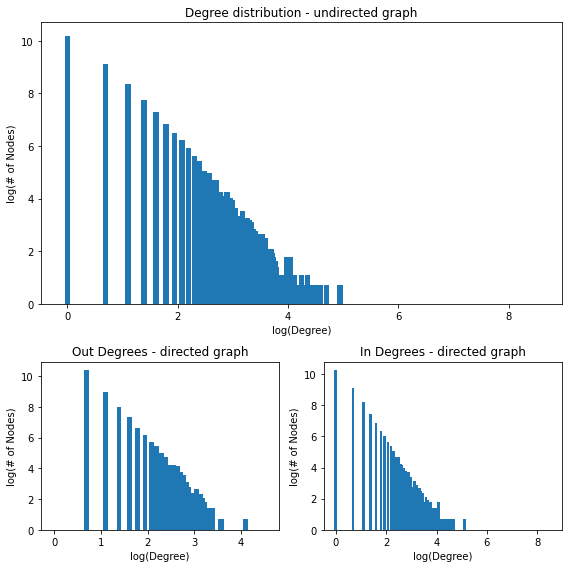

In [133]:
deg_sequence = sorted((d for n, d in G_undirected.degree()), reverse=True)
out_sequence_directed = sorted((d for n,d in G_directed.out_degree()), reverse=True)
in_sequence_directed = sorted((d for n,d in G_directed.in_degree()), reverse=True)

unique, counts = np.unique(deg_sequence, return_counts=True)
out_unique, out_counts = np.unique(out_sequence_directed, return_counts=True)
in_unique, in_counts = np.unique(in_sequence_directed, return_counts=True)

fig = plt.figure("Degrees for directed and undirected graphs", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
unique, counts = (np.unique(deg_sequence, return_counts=True))
ax0.bar(np.log(unique), np.log(counts), width=0.1)
ax0.set_title("Degree distribution - undirected graph")
ax0.set_xlabel("log(Degree)")
ax0.set_ylabel("log(# of Nodes)")


ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.bar(np.log(out_unique + 1), np.log(out_counts), width=0.1)
ax1.set_title("Out Degrees - directed graph")
ax1.set_xlabel("log(Degree)")
ax1.set_ylabel("log(# of Nodes)")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(np.log(in_unique + 1), np.log(in_counts), width=0.1)
ax2.set_title("In Degrees - directed graph")
ax2.set_xlabel("log(Degree)")
ax2.set_ylabel("log(# of Nodes)")

fig.tight_layout()
plt.show()

In [93]:
in_unique

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   42,   43,   44,
         45,   46,   47,   48,   49,   50,   51,   52,   54,   55,   56,
         58,   59,   60,   62,   64,   65,   67,   68,   72,   73,   74,
         77,   78,   79,   82,   83,   87,   88,   89,   91,   92,   93,
         94,   96,   97,  100,  108,  110,  115,  117,  118,  121,  131,
        139,  144,  155,  158,  164,  171,  174,  179,  183,  198,  203,
        212,  213,  218,  241,  244,  307,  333,  338,  368,  389,  392,
        393,  462,  470,  473,  485,  508,  594,  616,  750,  765,  788,
       1429, 1925, 2030, 2474, 3885, 4825])

## Average Degree of graph - Random graph

In [112]:
average_deg_undirected = sum(deg_sequence)/len(G_undirected.nodes())
average_deg_directed = sum(out_sequence_directed)/len(G_directed.nodes())

print(average_deg_directed, average_deg_undirected)

p_directed = average_deg_directed/len(G_directed.nodes())
p_undirected = average_deg_undirected/len(G_undirected.nodes())

print(p_directed, p_undirected, len(G_directed.nodes()), len(G_undirected.nodes()))

# Create random graphs


G_rand_undirected = nx.fast_gnp_random_graph(len(G_undirected.nodes()), p_undirected, seed=None, directed=False)
G_rand_directed = nx.fast_gnp_random_graph(len(G_directed.nodes()), p_directed, seed=None, directed=True)

print(sum(sorted((d for n, d in G_rand_undirected.degree()), reverse=True))/len(G_rand_undirected.nodes()))
print(sum(sorted((d for n, d in G_rand_directed.degree()), reverse=True))/len(G_rand_directed.nodes()))

1.7339675386990445 3.225393249050778
3.617406305960372e-05 6.72882139827842e-05 47934 47934
3.202236408394876
3.494847081403597


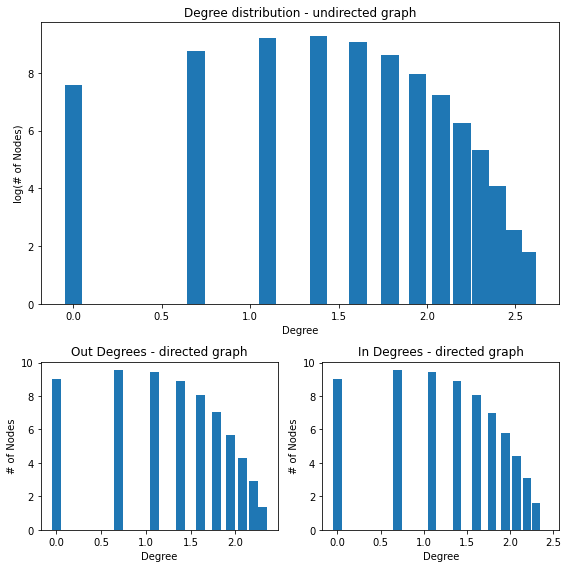

In [117]:
deg_sequence_rand = sorted((d for n, d in G_rand_undirected.degree()), reverse=True)
out_sequence_directed_rand = sorted((d for n,d in G_rand_directed.out_degree()), reverse=True)
in_sequence_directed_rand = sorted((d for n,d in G_rand_directed.in_degree()), reverse=True)

unique_rand, counts_rand = np.unique(deg_sequence_rand, return_counts=True)
out_unique_rand, out_counts_rand = np.unique(out_sequence_directed_rand, return_counts=True)
in_unique_rand, in_counts_rand = np.unique(in_sequence_directed_rand, return_counts=True)

fig = plt.figure("Degrees for directed and undirected graphs", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
unique, counts = (np.unique(deg_sequence, return_counts=True))
ax0.bar(np.log(unique_rand + 1), np.log(counts_rand), width=0.1)
ax0.set_title("Degree distribution - undirected graph")
ax0.set_xlabel("Degree")
ax0.set_ylabel("log(# of Nodes)")


ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.bar(np.log(out_unique_rand + 1), np.log(out_counts_rand), width=0.1)
ax1.set_title("Out Degrees - directed graph")
ax1.set_xlabel("Degree")
ax1.set_ylabel("# of Nodes")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(np.log(in_unique_rand + 1), np.log(in_counts_rand), width=0.1)
ax2.set_title("In Degrees - directed graph")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

## Sampling similarity across subreddits

In [120]:
ft_model = create_fasttext_model('training_data.txt')

Read 7M words
Number of words:  25591
Number of labels: 0
Progress: 100.0% words/sec/thread:   52422 lr:  0.000000 avg.loss:  2.191948 ETA:   0h 0m 0s 38.5% words/sec/thread:   52776 lr:  0.030740 avg.loss:  2.228413 ETA:   0h 0m29s 98.1% words/sec/thread:   52439 lr:  0.000926 avg.loss:  2.191348 ETA:   0h 0m 0s


In [122]:
# WARNING, WARNING, WARNING - THIS IS A HEFTY CHONKER, TAKES A LONG TIME TO RUN
inp = input("YA'LL SURE YA WANNA RUN THIS? Takes a looooooong time, like 15 minutes long")

if inp == 'y':
    sims = sample_similarity(data, samples=1000)

Oscars 5580
OutOfTheLoop 2069
USNEWS 6
boxoffice 969
entertainment 34266
news 51510
offbeat 103
television 14514
willsmith 1609
worldnews 2072


100%|██████████████████████████████████████████| 10/10 [28:03<00:00, 168.37s/it]


In [126]:
[(key, sim.mean()) for key, sim in sims.items()]

[('Oscars', 0.5734081361840402),
 ('OutOfTheLoop', 0.6267408389493618),
 ('USNEWS', 0.7517130391465293),
 ('boxoffice', 0.6556357684156545),
 ('entertainment', 0.5915876663660113),
 ('news', 0.5885688143422156),
 ('offbeat', 0.6371274988840921),
 ('television', 0.6832170959722129),
 ('willsmith', 0.6446319649818191),
 ('worldnews', 0.62317395577479)]

# Methods for graph analysis

We wanted to analyze how each comment and submission interacts with one another, and the most optimal way, we decided, was to create a graph where the nodes are unique users and the edges their interactions with other comments or submissions. In all cases, these are weighted, but we consider them either directed or undirected. In the undirected case, the weight is simply the sum of replies one user has made to another user's submissions (comments or posts) and vice versa, in the directed case we simply keep track of these two values independently.

## The degree distribution of the graph

First, we wanted to find out if the graph we had created modelled something natural, and not just random interactions between random users. To do this, we looked at the degree distribution of the created graph.

Looking at the degree distribution of the graph made by linking redditors by comments and submissions, we see that there is a clear tendency towards most nodes having an out degree of 0, as seen by the plot. The distribution of nodes seems to follow a logarithmic trend, this is especially evident when looking at the in-degree distribution of the directed graph. Here, very few nodes have an extremely high in-degree, most likely indicating those who have posted either very popular comments or are submission 'owners' of popular submissions.

![](/images/non_random.png)

We compare this to a random distribution created by iterating through each node and adding edges to each other node with probability p, where p is given by:

$$p = \frac{k_{\mu}}{N-1}$$

Where $k_{\mu}$ is the average degree of a given node in the network. Our hypothesis is that the degree distribution of a random network should be quite different than that of the redditor network

![](/images/random.png)

We see that the two graphs look quite dissimlar, implying that the graph of redditors indeed is a natural graph, rather than a purely random one.


## Analyzing modularity in the graph

As we want to examine how much people branch out from just one subreddit, we use modularity to examine this. Modularity is a measure of how well a given community 'fits' a graph. That is, given a graph and a unique set of nodes for each possible community, the modularity weighs how likely a node in any community is to branch out to other communities, weighted by how likely they are to stay within their own community. A modularity close to 0 implies that there is no inherent community structure, a value close to 1 implies that the modularity structure given is most likely a true indication of the communities, while one close to -1 implies the wrong communities. We group each user in a community based on which subreddit they have made most submissions to, and then calculate the modularity of the resulting graph. As a baseline, we use Louvain's algorithm which optimizes communities in the graph, so as to produce the highest possible modularity. Note, that while we only work with 11 communities in the case of subreddits, Louvain's algorithm can create as many number of communities as will needed to maximize the modularity.

The values for modularity were **0.581** and **0.784** for assigning users to community based on their most popular subreddit and by Louvain's algorithm. Both of these values are quite high. Louvain's algorithm is of course expected to give a high value in any graph were any type of community, explicit or otherwise exists. The high value of modularity when simply assigning by popularity is interesting, however. This could imply, that redditors in this case, primarily stick to one or a few subreddits, rather than branch out to many.



# Text analysis

To better test our hypothesis of the forums becoming 'echo chambers' for the same opinions, we wanted to look at two things in particular: How much 'the same things' are said across each subreddit, as well as about the discussion in general. We also wanted to analyze the general sentiment of across the subreddits, to see if there was any indication that particularly negative or positive content was being propagated, adding to the 'echo chamber' factor.


## Analyzing sentiment scores

To get the sentiment score, we use VADER (https://www.researchgate.net/publication/275828927_VADER_A_Parsimonious_Rule-based_Model_for_Sentiment_Analysis_of_Social_Media_Text). The strength of VADER being that it is fairly resistant to things that confuse other algorithms for the same purpose; typically sentiment analysis algorithms work pretty straightforwardly, adding postive sentiment for each positive word in a text, vice versa for negative. The obvious problem here, being with more complex sequences of words, such as those that contain negations or strength indicators, for example; 'not good' and 'extremely bad' being two examples of such. VADER fixes this by considering not only single words at a time, but a combination of different n-grams, sequences of number of words, this allows it far more consideration of context than other approaches.

With this, we hope to find if any subreddits stand out particularly if they diverge fra from neutral, 0 sentiment score, meaning they are either overly positive or overly negative. This could particularly be important in the debate of internet forums becoming 'echo chambers' for negative emotions, more than places for actual discourse.

(We would also have liked to use this for comparing sentiment score to comment score, but due to the unreliability of upvotes/downvotes, we did not go through with this idea). The results from the sentiment analysis can be seen below.

1. television': 0.04185013090808849,
1.  'willsmith': 0.020197949036668706,
1.  'entertainment': 0.00014266911807619216,
1.  'Oscars': 0.021183817204300976,
1.  'OutOfTheLoop': 0.050206621556307326,
1.  'boxoffice': 0.03953054695562434,
1.  'news': 0.02232362648029532,
1. 'worldnews': 0.022202027027027012,
1. 'offbeat': -0.03620582524271847,
1.  'USNEWS': -0.12266666666666665

What is most interesting here is probably ht e outlier that is USNEWS... The VADER implementation generally advises, that one a sentiment score between -0.05 and 0.05 should be considered as neutral, by this logic, only the USNEWS and just barely OutOfTheLoop, come by as negative and postiive respectively. USNEWS might be explainable - the immediate reaction by the hollywoord and other larger actors guild organisations (organisations that one would think USNEWS would focus on), was to denounce Will Smith as the aggressor. This is expressed in examples such as Will Smith being barred from the Oscars the next 20 years.

Of course the body of a submission does not wholly explain the body of each comment, but it lends itself somewhat to intuition, that the comments of a submission be more likely to follow the sentiment of the submission, than not. Analyzing in depth whether or not comments follow the submission in sentiment would be interesting in a future study.


## Wordcloud and Joke Collogation

To get an idea about the debate about the slap, we divide the comments into documents and create wordclouds based on the TF-IDF scores. This is because wordclouds are a very visual way of summarizing a big corpora of documents. Hence, it allows us to combine the computational power of a computer with the human power of pattern recognition and logical deduction. The process is the following. First we decide what category to group them by. For example, let’s work with subreddit, such that each subreddit represents one document. Then to create the documents, we loop over all the posts (i.e. submissions and comments), and we tokenize, stem and remove stopwords. Then for each unique word that is left in the post, we add that word to the document with a score of one. This means that when we’re done iterating over the entire dataset, for each document each word in that document has a word count that represents the number of posts from that category that contains that word - not the number of appearances of that word in total. The reason why we do this is to downweigh the long posts. Let’s imagine what would happen if we didn’t. Then words that are important in long posts would have a much higher score than the important words in shorter posts. This would bias our analysis towards the long comments, and we wan’t to capture the variety of the debate. 
Now we can calculate the TF-IDF scores for each word in each document, and use that to plot the wordclouds. The TF-IDF score for the word t in document d is defined as follows:

$$TF-IDF(t,d) = \frac{f_{t,d}}/{\sum_{t\in d} f_t,d} \cdot \log \frac {N}{|\{d\in D|t\in d\}|}$$

Here, D is the set of documents, i.e the corpora, and f_{t,d} is the raw count of the word t in document d. In the practical implementation in this exercise however, we don’t divide by the total number of words in the document, $$\sum_{t\in d} f_t,d$$. This is because we only use the TF-IDF scores to compare the words within documents, so that operation just scales the scores, and doesn’t change the relations between them. 
With that said, let’s look at some word clouds. First we will examine the division we just talked about, where each document represents a subreddit, and we will only examine the 9 largest. 

![](/images/wordcloud_subreddit.png)
Here we see that unsurprisingly one word that apears very often is ‘joke’. Therefore, let’s take a look at some of the collocations of the word ‘joke’ in the dataset.
![](/images/wordcloud_topic.png)

Even here we see that some of the comments actually defend Will for his actions. One example is the last one that says “it’s possible to try to laugh off a joke and realize you’re actually hurt (...)”. Some people also say that the joke was tasteless. However, most of them seem to defend Chris Rock even though they think the joke is tasteless
Furthermore, we can see that even though we’re only looking at posts are reposts to comments about either Will Smith, his wife, Chris Rock, the slap and the Oscars, many other words come into play in some of the subreddits, e.g. worldnews, boxoffice and offbeat. This is interesting as it shows how unfocused a discussion can be, and how fast the attention of humas can wander off - especially on the internet. Another interesting thing is the willsmith subreddit. Here, none of the dominant words from the other subreddits are not nearly as dominant. This indicates that on the willsmith subreddit they didn’t really care that much about the slap. Admittedly, ‘joke’, ‘wife’, ‘jada’ etc appear here as will, but many other words are just as important.
Let’s move on to a wordcloud plot where we have divided the words according to topic, that is each of the elements in [Chris Rock, Will Smith, Slap, Oscar, Jada Pinkett] represent a document. Note that here, each post can mention multiple topics, so the same post can be accounted in multiple documents.
[WORDCLOUD]
Here we see a much bigger variation, and also, many of the words seem a bit random. This is because we only have 5 documents in this case, and looking at the TF-IDF equation, if a word appears in all the documents, the TF-IDF score becomes zero. However, it is interesting, that words like ‘polygamous’, ‘monogamy’ and ‘soulmate’ appear frequently in the topic of jada smith. This is interesting because it aligns with the general tendency to assign these sort of “soft” values to the women.
Now let’s move on to the graph analysis


## Analyzing syntatic simliarity

Another tool we used to analyze the general similarity of the text within subreddits was the syntactic similarity of each comment in a subreddit when considering the other comments in that subreddit, here, we use the Facebook-developed algorithm: Fastext. This allows us to vectorize each submission text to obtain a vector with 100 features that describe the abstract syntatic content of a given submission. In practice, these vectors are created by considering submissions that contain many words that appear in the same contexts as syntactically similar, specifically, it uses a skipgram model to obtain vector embeddings.

After creating the vectors for each submission, we can compare the syntactic similarity of each submission in a given subreddit to each other submission in the same subreddit by simply comparing the similarity of their respective vectors. Finally, we can weigh these simliarities together to obtain an average 'simliarity score' for each subreddit. The actual vector similarities for each pair of two vectors, were calculated by the cosine simliarity:

$$sim(v_1, v_2) = \frac{v_1 \bullet v_2}{||v_1|| \times ||v_2||}$$

However, in practice, since there are so many unique submissions, it is completely infeasible to compare each comment in each subreddit to each other comment, as this would lead to hundreds of billions of comparisons. Instead we sample randomly from the pool of submissions from each subreddit, and calculate the simliarity score between these samples instead. With this, we assume that the average simliarity score of our samples are somewhat representative of the overall simliarity score of their respective subreddits.

The results for the syntatic simliarity test were as follows:

1. 'Oscars': 0.5734081361840402
1. 'OutOfTheLoop', 0.6267408389493618
1. 'USNEWS', 0.7517130391465293
1. 'boxoffice', 0.6556357684156545
1. 'entertainment', 0.5915876663660113
1. 'news', 0.5885688143422156
1. 'offbeat', 0.6371274988840921
1. 'television', 0.6832170959722129
1. 'willsmith', 0.6446319649818191
1. 'worldnews', 0.62317395577479

As it can be seen, the greatest amount of syntactc simliarity is found in USNEWS - most likely explainable as most content there are of the same type - news articles. Another interesting point, however, is how generally high this syntactic similarity score is. 


# The Will Smith slap

At the 94th academy awards on march 27, 2022, Will Smith slapped Chris Rock as a reaction to Chris Rock telling a joke about Will Smith's wife, Jada Pinkett. This created an immediate online reaction, particularly on reddit, where many subreddits were abuzz with the news. 

Looking qualitatively at many of the comments and posts, we hypotheized, that a certain, possibly unhealthy discussion was being propagated by the forums, with some subreddits being heavily biased towards either one side or the other, particularly in regards to Reddit's (partial) role as a place for discusison. Instead of discussion, this could potentially create a sort of 'echo chamber' effect, where instead of people meeting to exchange different views, instead propagate only one viewpoint and simply reinforce this for each other.

This 'echo chamber' effect especially is interesting, as it has been seen on sites before such as QAnon to have potentially devastating effects in situations such as the storming of the capitol building in the US.

In this report, we analyze data collected from Reddit in the days following the slap, and use methods to discern whether or not there is the proposed 'echo chamber' effect, and whether or not the viewpoints propagated on the sites are wholly of one sentiment or another. We present our methods for scraping, cleaning and preparing the data for use, as well our methods for detecting the syntactic content of the comments, as well as the sentiment. 

Furthermore, we conclude, that while it may seem qualitatively so, that the echo chamber effect is quite real, we find no hard evidence to support this. Some results such as the modularlity of the graphs created seem to suggest some trends of 'echo chambering', but without a baseline with regards to those same subreddits before the Will Smith slap, we cannot conclude anything meaningful.

Finally, we motivate the continuation of studies about this subject, particularly to obtain meaningful baselines for the subreddits examined, as without prior knowledge about the general behavior of users on these subreddits, it is difficult to say if any one finding is atypical to the Will Smith slap in particular. 